In [47]:
import os
import numpy as np
from scipy import stats

import torch

import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.medical_imaging import get_chexpert
from source.utils.metrics import auroc, aod, eod, spd, get_prs, get_tprs, get_fprs

os.makedirs(PLOTS_PATH, exist_ok=True)

In [48]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

model = ["resnet18", "resnet34", "resnet50"][2]

pas = ["old", "woman", "white"]
pa = 0 # 0, 1, 2

In [49]:
full_ds, _, _ = get_chexpert(load_to_ram=False)

run_path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds))

y_fair_t = full_ds.targets[fair_inds]
a_fair_t = full_ds.protected_attributes[pa, fair_inds]
y_val_t = full_ds.targets[val_inds]
a_val_t = full_ds.protected_attributes[pa, val_inds]

# switch 0 / 1 in protected attribute
pas = ["young", "man", "non-white"]
a_fair_t = 1 - a_fair_t
a_val_t = 1 - a_val_t

# switch label
# y_fair_t = 1 - y_fair_t
# y_val_t = 1 - y_val_t

p_a_fair = a_fair_t.float().mean().item() * 100
p_y_fair = y_fair_t.float().mean().item() * 100

# patients general 65401
# patients with race 58010
24638 24638


In [50]:
# load probits
fair_probits, val_probits = list(), list()
for mseed in method_seeds:
    path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{mseed}_dseed{dseed}")

    # don't do fairness ensemble on medical imaging - use this split as test dataset
    fp = torch.load(os.path.join(path, f"fair_probits.pt"))
    #fp = 1 - fp
    fair_probits.append(fp)
    vp = torch.load(os.path.join(path, f"val_probits.pt"))
    #vp = 1 - vp
    val_probits.append(vp)

In [51]:
# calculate accuracies and fairness measures
fair_aurocs, val_aurocs = list(), list()
fair_spds, val_spds = list(), list()
fair_eods, val_eods = list(), list()
fair_aods, val_aods = list(), list()

for m in range(len(method_seeds)):
    fair_aurocs.append([auroc(p[:, 1], y_fair_t) for p in fair_probits[m]])
    val_aurocs.append([auroc(p[:, 1], y_val_t) for p in val_probits[m]])

    fair_spds.append([spd(p.argmax(dim=1), a_fair_t) for p in fair_probits[m]])
    val_spds.append([spd(p.argmax(dim=1), a_val_t) for p in val_probits[m]])

    fair_eods.append([eod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_eods.append([eod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])

    fair_aods.append([aod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_aods.append([aod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])

In [52]:
fair_m_aurocs = list()
fair_m_spds = list()
fair_m_eods = list()
fair_m_aods = list()

for m in range(len(method_seeds)):
    fair_m_aurocs.append(auroc(torch.mean(fair_probits[m], dim=0)[:, 1], y_fair_t))

    fair_m_spds.append(spd(torch.mean(fair_probits[m], dim=0).argmax(dim=1), a_fair_t))
    
    fair_m_eods.append(eod(torch.mean(fair_probits[m], dim=0).argmax(dim=1), y_fair_t, a_fair_t))

    fair_m_aods.append(aod(torch.mean(fair_probits[m], dim=0).argmax(dim=1), y_fair_t, a_fair_t))

In [53]:
%%script false --no-raise-error

for m, mseed in enumerate(method_seeds):
    f, axs = plt.subplots(1, 3, figsize=(11, 3))
    axs[0].scatter(fair_aurocs[m], fair_spds[m], c=val_spds[m], cmap="viridis_r")
    axs[0].scatter(np.mean(fair_aurocs[m]), np.mean(fair_spds[m]), marker="*", c="black", s=150)
    axs[0].scatter(fair_m_aurocs[m], fair_m_spds[m], marker="*", c="red", s=150)
    axs[0].set_ylabel("SPD")
    axs[1].scatter(fair_aurocs[m], fair_eods[m], c=val_eods[m], cmap="viridis_r")
    axs[1].scatter(np.mean(fair_aurocs[m]), np.mean(fair_eods[m]), marker="*", c="black", s=150)
    axs[1].scatter(fair_m_aurocs[m], fair_m_eods[m], marker="*", c="red", s=150)
    axs[1].set_ylabel("EOD")
    axs[2].scatter(fair_aurocs[m], fair_aods[m], c=val_aods[m], cmap="viridis_r")
    axs[2].scatter(np.mean(fair_aurocs[m]), np.mean(fair_aods[m]), marker="*", c="black", s=150)
    axs[2].scatter(fair_m_aurocs[m], fair_m_aods[m], marker="*", c="red", s=150)
    axs[2].set_ylabel("AOD")

    for ax in axs.flatten():
        ax.set_xlabel("AUROC")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))

    f.tight_layout()
    plt.show()

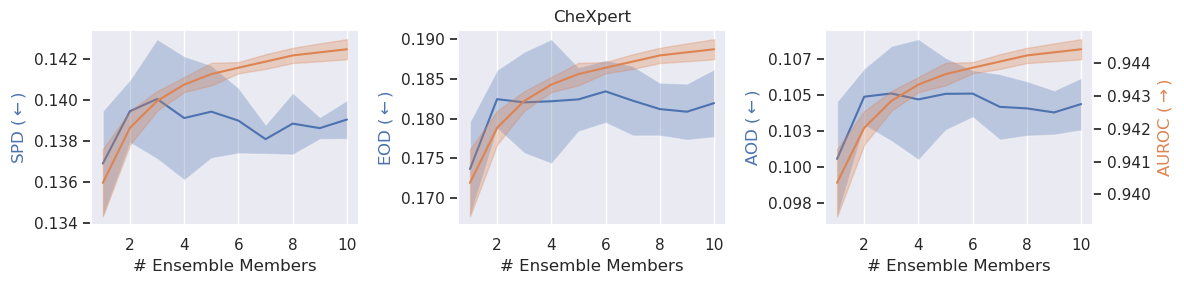

In [54]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))

fair_fm_aurocs, fair_fm_spds, fair_fm_eods, fair_fm_aods = list(), list(), list(), list()

for m in range(len(method_seeds)):

    fair_fm_aurocs_, fair_fm_spds_, fair_fm_eods_, fair_fm_aods_ = list(), list(), list(), list()

    for em in ensemble_members:
        preds = torch.mean(fair_probits[m][:em], dim=0)
        fair_fm_aurocs_.append(auroc(preds[:, 1], y_fair_t))
        preds = preds.argmax(dim=1)
        fair_fm_spds_.append(spd(preds, a_fair_t))
        fair_fm_eods_.append(eod(preds, y_fair_t, a_fair_t))
        fair_fm_aods_.append(aod(preds, y_fair_t, a_fair_t))

    fair_fm_aurocs.append(fair_fm_aurocs_)
    fair_fm_spds.append(fair_fm_spds_)
    fair_fm_eods.append(fair_fm_eods_)
    fair_fm_aods.append(fair_fm_aods_)

fair_fm_aurocs = np.asarray(fair_fm_aurocs)
fair_fm_spds = np.asarray(fair_fm_spds)
fair_fm_eods = np.asarray(fair_fm_eods)
fair_fm_aods = np.asarray(fair_fm_aods)

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(ensemble_members, np.mean(fair_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                       np.mean(fair_fm_spds, axis=0) - np.std(fair_fm_spds, axis=0), 
                       np.mean(fair_fm_spds, axis=0) + np.std(fair_fm_spds, axis=0), alpha=0.3)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("SPD ($\\leftarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(fair_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members, 
                       np.mean(fair_fm_eods, axis=0) - np.std(fair_fm_eods, axis=0), 
                       np.mean(fair_fm_eods, axis=0) + np.std(fair_fm_eods, axis=0), alpha=0.3)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("EOD ($\\leftarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(fair_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members, 
                       np.mean(fair_fm_aods, axis=0) - np.std(fair_fm_aods, axis=0), 
                       np.mean(fair_fm_aods, axis=0) + np.std(fair_fm_aods, axis=0), alpha=0.3)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("AOD ($\\leftarrow$)", color="C0")

for ax in acc_axs:
    ax.plot(ensemble_members, np.mean(fair_fm_aurocs, axis=0), "-", c="C1")
    ax.fill_between(ensemble_members, 
                    np.mean(fair_fm_aurocs, axis=0) - np.std(fair_fm_aurocs, axis=0), 
                    np.mean(fair_fm_aurocs, axis=0) + np.std(fair_fm_aurocs, axis=0), alpha=0.3, color="C1")
    
axs[1].set_title("CheXpert")

for ax in axs.flatten():
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("AUROC ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}.pdf"))
plt.show()

In [55]:
# test for significance of disparate benefits
fair_fm_delta_aurocs = (fair_fm_aurocs[:, -1] - np.mean(np.asarray(fair_aurocs), axis=1))
fair_fm_delta_spds = (fair_fm_spds[:, -1] - np.mean(np.asarray(fair_spds), axis=1))
fair_fm_delta_eods = (fair_fm_eods[:, -1] - np.mean(np.asarray(fair_eods), axis=1))
fair_fm_delta_aods = (fair_fm_aods[:, -1] - np.mean(np.asarray(fair_aods), axis=1))

for s, samples in enumerate([fair_fm_delta_aurocs, fair_fm_delta_spds, fair_fm_delta_eods, fair_fm_delta_aods]):
    # perform t-test for the null hypothesis that the mean of the samples is equal to zero
    t_statistic, p_value = stats.ttest_1samp(samples, 0)
    if p_value < 0.05:
        print(f"$\\boldsymbol{'{'}{np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}{'}'}$", end="")
    else:
        print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")

$\boldsymbol{0.005_{\pm 0.000}}$ & $\boldsymbol{0.001_{\pm 0.000}}$ & $\boldsymbol{0.008_{\pm 0.004}}$ & $\boldsymbol{0.003_{\pm 0.001}}$

In [56]:
for s, samples in enumerate([fair_fm_aurocs, fair_fm_spds, fair_fm_eods, fair_fm_aods]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")

$0.943_{\pm 0.001}$ & $0.139_{\pm 0.002}$ & $0.181_{\pm 0.006}$ & $0.104_{\pm 0.003}$

In [57]:
for s, samples in enumerate([np.mean(np.asarray(fair_aurocs), axis=1), 
                             np.mean(np.asarray(fair_spds), axis=1), 
                             np.mean(np.asarray(fair_eods), axis=1), 
                             np.mean(np.asarray(fair_aods), axis=1)]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")

$0.940_{\pm 0.000}$ & $0.138_{\pm 0.001}$ & $0.174_{\pm 0.003}$ & $0.101_{\pm 0.001}$

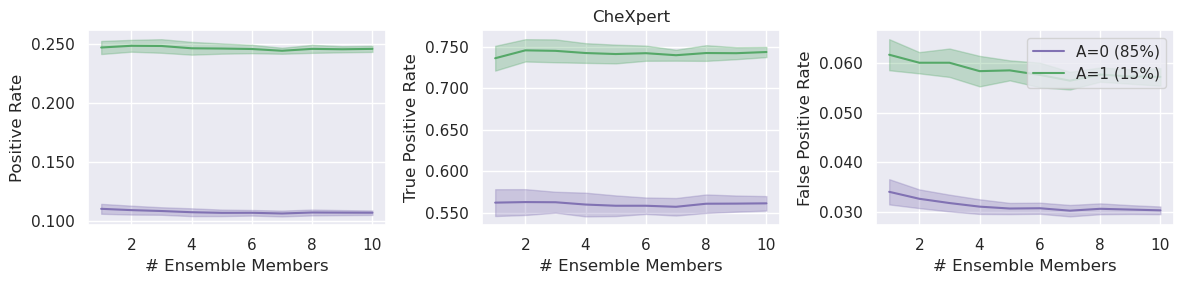

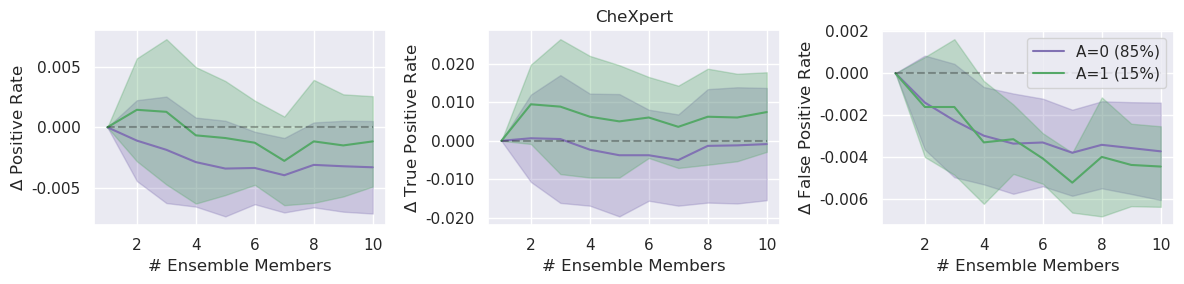

In [58]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))

for delta in [False, True]:

    fair_fm_prs_1, fair_fm_prs_0 = list(), list()
    fair_fm_tprs_1, fair_fm_tprs_0 = list(), list()
    fair_fm_fprs_1, fair_fm_fprs_0 = list(), list()
    

    for m in range(len(method_seeds)):

        fair_fm_prs_1_, fair_fm_prs_0_ = list(), list()
        fair_fm_tprs_1_, fair_fm_tprs_0_ = list(), list()
        fair_fm_fprs_1_, fair_fm_fprs_0_ = list(), list()

        for em in ensemble_members:
            preds = torch.mean(fair_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_fair_t)
            tpr1, tpr0 = get_tprs(preds, y_fair_t, a_fair_t)
            fpr1, fpr0 = get_fprs(preds, y_fair_t, a_fair_t)
            fair_fm_prs_1_.append(pr1)
            fair_fm_prs_0_.append(pr0)
            fair_fm_tprs_1_.append(tpr1)
            fair_fm_tprs_0_.append(tpr0)
            fair_fm_fprs_1_.append(fpr1)
            fair_fm_fprs_0_.append(fpr0)
            
        if delta:
            fair_fm_prs_1.append([t - fair_fm_prs_1_[0] for t in fair_fm_prs_1_])
            fair_fm_prs_0.append([t - fair_fm_prs_0_[0] for t in fair_fm_prs_0_])
            fair_fm_tprs_1.append([t - fair_fm_tprs_1_[0] for t in fair_fm_tprs_1_])
            fair_fm_tprs_0.append([t - fair_fm_tprs_0_[0] for t in fair_fm_tprs_0_])
            fair_fm_fprs_1.append([t - fair_fm_fprs_1_[0] for t in fair_fm_fprs_1_])
            fair_fm_fprs_0.append([t - fair_fm_fprs_0_[0] for t in fair_fm_fprs_0_])

        else:
            fair_fm_prs_1.append(fair_fm_prs_1_)
            fair_fm_prs_0.append(fair_fm_prs_0_)
            fair_fm_tprs_1.append(fair_fm_tprs_1_)
            fair_fm_tprs_0.append(fair_fm_tprs_0_)
            fair_fm_fprs_1.append(fair_fm_fprs_1_)
            fair_fm_fprs_0.append(fair_fm_fprs_0_)

    fair_fm_prs_1 = np.asarray(fair_fm_prs_1)
    fair_fm_prs_0 = np.asarray(fair_fm_prs_0)
    fair_fm_tprs_1 = np.asarray(fair_fm_tprs_1)
    fair_fm_tprs_0 = np.asarray(fair_fm_tprs_0)
    fair_fm_fprs_1 = np.asarray(fair_fm_fprs_1)
    fair_fm_fprs_0 = np.asarray(fair_fm_fprs_0)

    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    for t, test_pr in enumerate([fair_fm_prs_0, fair_fm_prs_1]):
        axs[0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0].set_ylabel("$\Delta$ Positive Rate" if delta else "Positive Rate")
    for t, test_pr in enumerate([fair_fm_tprs_0, fair_fm_tprs_1]):
        axs[1].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[1].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1].set_ylabel("$\Delta$ True Positive Rate" if delta else "True Positive Rate")
    for t, test_pr in enumerate([fair_fm_fprs_0, fair_fm_fprs_1]):
        axs[2].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
        axs[2].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[2].set_ylabel("$\Delta$ False Positive Rate" if delta else "False Positive Rate")
    axs[2].legend(loc="upper right")

    axs[1].set_title("CheXpert")

    for ax in axs:
        # ax.yaxis.grid(False)
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_delta_rates.pdf"))
    else:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_rates.pdf"))
    plt.show()

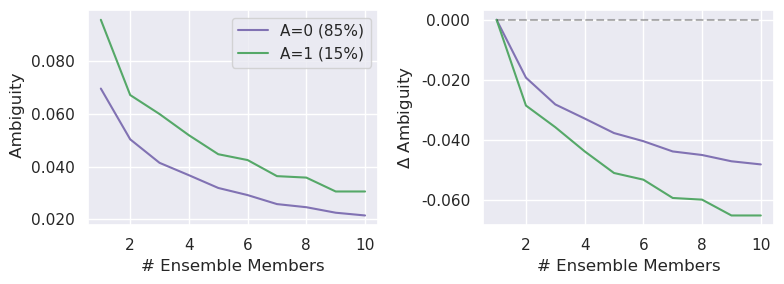

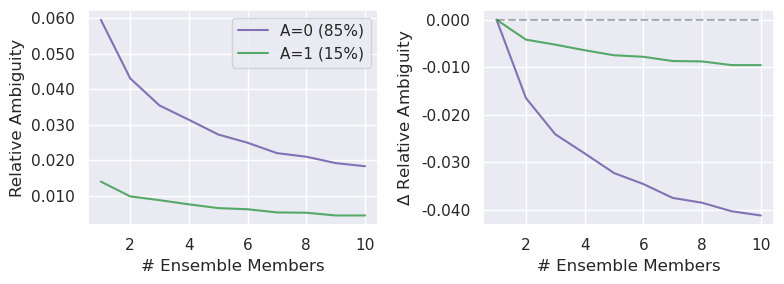

In [59]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))

for relative in [False, True]:

    f, axs = plt.subplots(1, 2, figsize=(8, 3))

    if relative:
        factors = [(100 - p_a_fair) / 100, p_a_fair / 100]
    else:
        factors = [1, 1]

    for delta in [False, True]:

        fair_m_arb_a1, fair_m_arb_a0 = list(), list()

        for em in ensemble_members:
            probits = torch.stack(fair_probits)
            S, M, N, P = probits.shape
            preds = torch.mean(probits[:, :em], dim=1).argmax(dim=2).sum(dim=0)
            ambiguity = ((preds != S) & (preds != 0)).float()

            fair_m_arb_a1.append(ambiguity[a_fair_t == 1].mean() * factors[1])
            fair_m_arb_a0.append(ambiguity[a_fair_t == 0].mean() * factors[0])

        if delta:
            orig = fair_m_arb_a1[0]
            fair_m_arb_a1 = [t - orig for t in fair_m_arb_a1]
            orif = fair_m_arb_a0[0]
            fair_m_arb_a0 = [t - orif for t in fair_m_arb_a0]

            for t, test_pr in enumerate([fair_m_arb_a0, fair_m_arb_a1]):
                axs[1].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
                axs[1].set_ylabel(f"$\Delta${' Relative' if relative else ''} Ambiguity")
            axs[1].hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)
            axs[0].legend(loc="upper right")
        else:
            for t, test_pr in enumerate([fair_m_arb_a0, fair_m_arb_a1]):
                axs[0].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
                axs[0].set_ylabel(f"{'Relative' if relative else ''} Ambiguity")

    for i, ax in enumerate(axs.flatten()):
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

    f.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_{'relative_' if relative else ''}ambiguity_a.pdf"))
    plt.show()

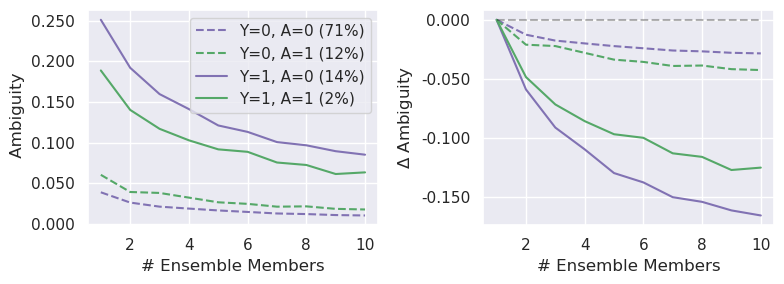

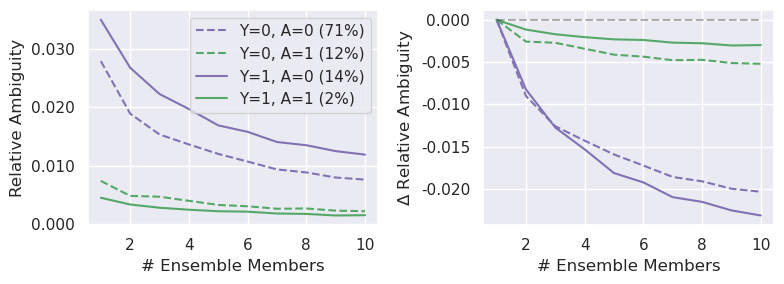

In [60]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))

for relative in [False, True]:

    f, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

    if relative:
        factors_ff = [[((100 - p_a_fair) / 100) * ((100 - p_y_fair) / 100), (p_a_fair / 100) * ((100 - p_y_fair) / 100)],
                      [((100 - p_a_fair) / 100) * (p_y_fair / 100), (p_a_fair / 100) * (p_y_fair / 100)]]
    else:
        factors_ff = [[1, 1], [1, 1]]
        factors_utk = [[1, 1], [1, 1]]

    for delta in [False, True]:

        fair_m_arb_y1_a1, fair_m_arb_y0_a1, fair_m_arb_y1_a0, fair_m_arb_y0_a0 = list(), list(), list(), list()

        for em in ensemble_members:
            probits = torch.stack(fair_probits)
            S, M, N, P = probits.shape
            preds = torch.mean(probits[:, :em], dim=1).argmax(dim=2).sum(dim=0)
            ambiguity = ((preds != S) & (preds != 0)).float()

            fair_m_arb_y1_a1.append(ambiguity[(y_fair_t == 1) & (a_fair_t == 1)].mean() * factors_ff[1][1])
            fair_m_arb_y0_a1.append(ambiguity[(y_fair_t == 0) & (a_fair_t == 1)].mean() * factors_ff[0][1])
            fair_m_arb_y1_a0.append(ambiguity[(y_fair_t == 1) & (a_fair_t == 0)].mean() * factors_ff[1][0])
            fair_m_arb_y0_a0.append(ambiguity[(y_fair_t == 0) & (a_fair_t == 0)].mean() * factors_ff[0][0])

        if delta:
            orig = fair_m_arb_y1_a1[0]
            fair_m_arb_y1_a1 = [t - orig for t in fair_m_arb_y1_a1]
            orig = fair_m_arb_y0_a1[0]
            fair_m_arb_y0_a1 = [t - orig for t in fair_m_arb_y0_a1]
            orig = fair_m_arb_y1_a0[0]
            fair_m_arb_y1_a0 = [t - orig for t in fair_m_arb_y1_a0]
            orig = fair_m_arb_y0_a0[0]
            fair_m_arb_y0_a0 = [t - orig for t in fair_m_arb_y0_a0]

            for t, test_pr in enumerate([fair_m_arb_y0_a0, fair_m_arb_y0_a1]):
                axs[1].plot(ensemble_members, test_pr, "--", color=["C4", "C2"][t], 
                            label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
            for t, test_pr in enumerate([fair_m_arb_y1_a0, fair_m_arb_y1_a1]):
                axs[1].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
            axs[1].set_ylabel(f"$\Delta${' Relative' if relative else ''} Ambiguity")
            axs[1].hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)
            axs[0].legend(loc="upper right")
        else:
            for t, test_pr in enumerate([fair_m_arb_y0_a0, fair_m_arb_y0_a1]):
                axs[0].plot(ensemble_members, test_pr, "--", color=["C4", "C2"][t], 
                            label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
            axs[0].set_ylabel(f"{'Relative' if relative else ''} Ambiguity")
            for t, test_pr in enumerate([fair_m_arb_y1_a0, fair_m_arb_y1_a1]):
                axs[0].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
            axs[0].set_ylabel(f"{'Relative' if relative else ''} Ambiguity")

    for i, ax in enumerate(axs.flatten()):
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

    f.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_{'relative_' if relative else ''}ambiguity_ya.pdf"))
    plt.show()

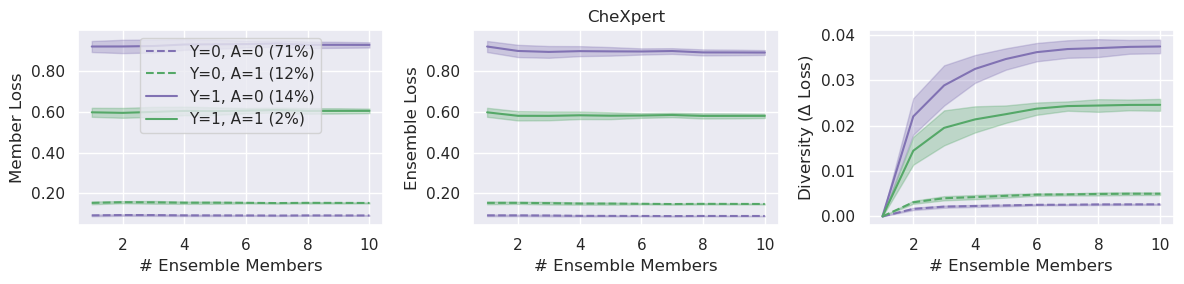

In [61]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))
eps = 1e-10

f, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
    
fair_ens_loss_y0_a1, fair_ens_loss_y1_a1, fair_ens_loss_y0_a0, fair_ens_loss_y1_a0 = list(), list(), list(), list()
fair_member_loss_y0_a1, fair_member_loss_y1_a1, fair_member_loss_y0_a0, fair_member_loss_y1_a0 = list(), list(), list(), list()
fair_m_div_y0_a1, fair_m_div_y1_a1, fair_m_div_y0_a0, fair_m_div_y1_a0 = list(), list(), list(), list()

for em in ensemble_members:
    probits = torch.stack(fair_probits)
    S, M, N, P = probits.shape
    preds = probits[:, :em]
    
    ens_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3, 
                                         index=y_fair_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0]

    fair_ens_loss_y1_a1.append(ens_loss[:, (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=1))
    fair_ens_loss_y0_a1.append(ens_loss[:, (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=1))
    fair_ens_loss_y1_a0.append(ens_loss[:, (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=1))
    fair_ens_loss_y0_a0.append(ens_loss[:, (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=1))

    member_loss = - torch.mean(torch.log(torch.gather(preds, dim=3, index=y_fair_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1]))), dim=1)[..., 0]

    fair_member_loss_y1_a1.append(member_loss[:, (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=1))
    fair_member_loss_y0_a1.append(member_loss[:, (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=1))
    fair_member_loss_y1_a0.append(member_loss[:, (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=1))
    fair_member_loss_y0_a0.append(member_loss[:, (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=1))

    diversity = torch.mean(torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3, 
                                                    index=y_fair_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])) / 
                                    (torch.gather(preds, dim=3, index=y_fair_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])) + eps))[..., 0], dim=1)
    fair_m_div_y1_a1.append(diversity[:, (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=1))
    fair_m_div_y0_a1.append(diversity[:, (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=1))
    fair_m_div_y1_a0.append(diversity[:, (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=1))
    fair_m_div_y0_a0.append(diversity[:, (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=1))

fair_member_loss_y0_a1 = torch.stack(fair_member_loss_y0_a1)
fair_member_loss_y1_a1 = torch.stack(fair_member_loss_y1_a1)
fair_member_loss_y0_a0 = torch.stack(fair_member_loss_y0_a0)
fair_member_loss_y1_a0 = torch.stack(fair_member_loss_y1_a0)
fair_ens_loss_y0_a1 = torch.stack(fair_ens_loss_y0_a1)
fair_ens_loss_y1_a1 = torch.stack(fair_ens_loss_y1_a1)
fair_ens_loss_y0_a0 = torch.stack(fair_ens_loss_y0_a0)
fair_ens_loss_y1_a0 = torch.stack(fair_ens_loss_y1_a0)
fair_m_div_y0_a1 = torch.stack(fair_m_div_y0_a1)
fair_m_div_y1_a1 = torch.stack(fair_m_div_y1_a1)
fair_m_div_y0_a0 = torch.stack(fair_m_div_y0_a0)
fair_m_div_y1_a0 = torch.stack(fair_m_div_y1_a0)


for t, test_ent in enumerate([fair_member_loss_y0_a0, fair_member_loss_y0_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([fair_member_loss_y1_a0, fair_member_loss_y1_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[0].set_ylabel("Member Loss")
axs[0].legend(loc="upper center")

for t, test_ent in enumerate([fair_ens_loss_y0_a0, fair_ens_loss_y0_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([fair_ens_loss_y1_a0, fair_ens_loss_y1_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[1].set_ylabel("Ensemble Loss")

for t, test_ent in enumerate([fair_m_div_y0_a0, fair_m_div_y0_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([fair_m_div_y1_a0, fair_m_div_y1_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[2].set_ylabel("Diversity ($\Delta$ Loss)")

axs[1].set_title("CheXpert")


for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
    if i % 3 < 2:
        ax.set_ylim(min(axs[0].get_ylim()[0], axs[1].get_ylim()[0]),
                    max(axs[0].get_ylim()[1], axs[1].get_ylim()[1]))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_losses_diversity.pdf"))
plt.show()

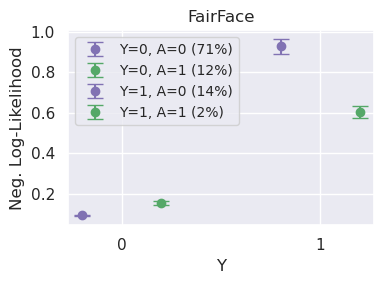

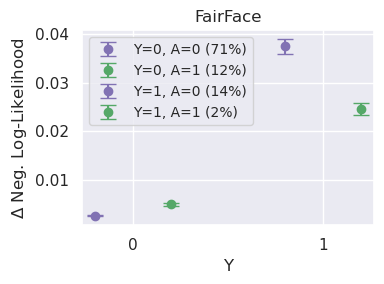

In [62]:
fair_member_loss_y0_a1, fair_member_loss_y1_a1, fair_member_loss_y0_a0, fair_member_loss_y1_a0 = list(), list(), list(), list()
fair_member_loss_a1, fair_member_loss_a0 = list(), list()
fair_ensemble_loss_y0_a1, fair_ensemble_loss_y1_a1, fair_ensemble_loss_y0_a0, fair_ensemble_loss_y1_a0 = list(), list(), list(), list()
fair_ensemble_loss_a1, fair_ensemble_loss_a0 = list(), list()

preds = torch.stack(fair_probits)
member_loss = - torch.log(torch.gather(preds, dim=3, index=y_fair_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])))[..., 0]

fair_member_loss_y1_a1 = member_loss[..., (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=2).reshape(1, -1)
fair_member_loss_y0_a1 = member_loss[..., (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=2).reshape(1, -1)
fair_member_loss_y1_a0 = member_loss[..., (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=2).reshape(1, -1)
fair_member_loss_y0_a0 = member_loss[..., (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=2).reshape(1, -1)
fair_member_loss_a1 = member_loss[..., a_fair_t == 1].mean(dim=2).reshape(1, -1)
fair_member_loss_a0 = member_loss[..., a_fair_t == 0].mean(dim=2).reshape(1, -1)

S, M, N, P = preds.shape
# m_preds = torch.mean(preds.reshape(S * M, N, P), keepdim=True, dim=0)
# ensemble_loss = - torch.log(torch.gather(m_preds, dim=2, 
#                                          index=y_fair_t.reshape(1, -1, 1).expand_as(m_preds[..., :1])))[0][..., 0]
ensemble_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3, 
                                         index=y_fair_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0]
fair_ensemble_loss_y1_a1 = ensemble_loss[..., (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_y0_a1 = ensemble_loss[..., (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_y1_a0 = ensemble_loss[..., (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_y0_a0 = ensemble_loss[..., (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_a1 = ensemble_loss[..., a_fair_t == 1].mean(dim=1).reshape(1, -1)
fair_ensemble_loss_a0 = ensemble_loss[..., a_fair_t == 0].mean(dim=1).reshape(1, -1)

#### Y
"""
plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([fair_member_loss_a0, fair_member_loss_a1]):
    bps.append(plt.boxplot(test_ent, positions=[t], widths=0.4, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("FairFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("A")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)") for t in range(2)])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_likelihood"))
plt.show()
"""

#### YA
"""
plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([fair_member_loss_y0_a0, fair_member_loss_y0_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 - 0.2], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
for t, test_ent in enumerate([fair_member_loss_y1_a0, fair_member_loss_y1_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 + 0.8], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("FairFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)") for t in range(2)])
plt.legent()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_likelihood.pdf"))
plt.show()

"""

plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([fair_member_loss_y0_a0, fair_member_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
for t, test_ent in enumerate([fair_member_loss_y1_a0, fair_member_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
# for t, test_ent in enumerate([fair_ensemble_loss_y0_a0, fair_ensemble_loss_y0_a1]):
#     plt.scatter([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
# for t, test_ent in enumerate([fair_ensemble_loss_y1_a0, fair_ensemble_loss_y1_a1]):
#     plt.scatter([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
plt.title("FairFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)") for t in range(2)])
plt.legend(fontsize="small")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_likelihood.pdf"))
plt.show()


# YA difference
fair_member_loss_y0_a0 = torch.mean(fair_member_loss_y0_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
fair_member_loss_y0_a1 = torch.mean(fair_member_loss_y0_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
fair_member_loss_y1_a0 = torch.mean(fair_member_loss_y1_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
fair_member_loss_y1_a1 = torch.mean(fair_member_loss_y1_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)

plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([fair_member_loss_y0_a0 - fair_ensemble_loss_y0_a0, 
                              fair_member_loss_y0_a1 - fair_ensemble_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
for t, test_ent in enumerate([fair_member_loss_y1_a0 - fair_ensemble_loss_y1_a0, 
                              fair_member_loss_y1_a1 - fair_ensemble_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_fair * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
plt.title("FairFace")
plt.ylabel("$\Delta$ Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)") for t in range(2)])
plt.legend(fontsize="small")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_likelihood_ratio.pdf"))
plt.show()

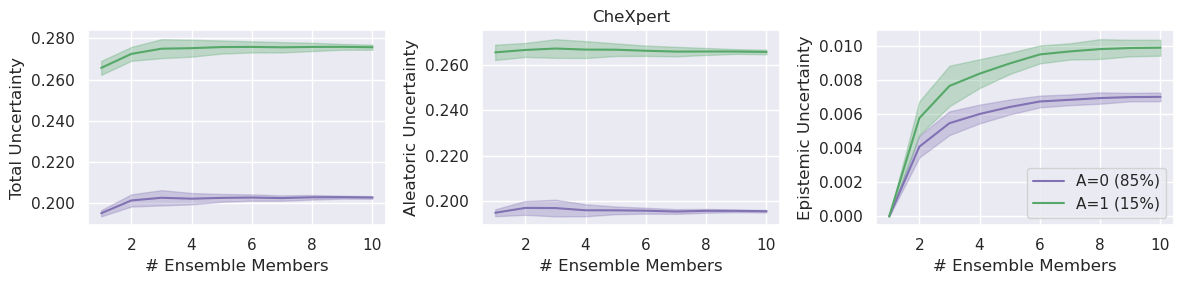

In [63]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))
eps = 1e-10

f, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
    
fair_m_total_1, fair_m_total_0 = list(), list()
fair_m_ale_1, fair_m_ale_0 = list(), list()
fair_m_epi_1, fair_m_epi_0 = list(), list()

for em in ensemble_members:
    probits = torch.stack(fair_probits)
    S, M, N, P = probits.shape
    preds = probits[:, :em]
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2)

    fair_m_total_1.append(total[:, a_fair_t == 1].mean(dim=1))
    fair_m_total_0.append(total[:, a_fair_t == 0].mean(dim=1))
    fair_m_ale_1.append(ale[:, a_fair_t == 1].mean(dim=1))
    fair_m_ale_0.append(ale[:, a_fair_t == 0].mean(dim=1))
    fair_m_epi_1.append((total[:, a_fair_t == 1] - ale[:, a_fair_t == 1]).mean(dim=1))
    fair_m_epi_0.append((total[:, a_fair_t == 0] - ale[:, a_fair_t == 0]).mean(dim=1))

fair_m_total_1 = torch.stack(fair_m_total_1)
fair_m_total_0 = torch.stack(fair_m_total_0)
fair_m_ale_1 = torch.stack(fair_m_ale_1)
fair_m_ale_0 = torch.stack(fair_m_ale_0)
fair_m_epi_1 = torch.stack(fair_m_epi_1)
fair_m_epi_0 = torch.stack(fair_m_epi_0)

for t, test_ent in enumerate([fair_m_total_0, fair_m_total_1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[0].set_ylabel("Total Uncertainty")
for t, test_ent in enumerate([fair_m_ale_0, fair_m_ale_1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[1].set_ylabel("Aleatoric Uncertainty")
for t, test_ent in enumerate([fair_m_epi_0, fair_m_epi_1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[2].set_ylabel("Epistemic Uncertainty")
    axs[2].legend(loc="lower right")

axs[1].set_title("CheXpert")

for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_uncertainty_a.pdf"))
plt.show()

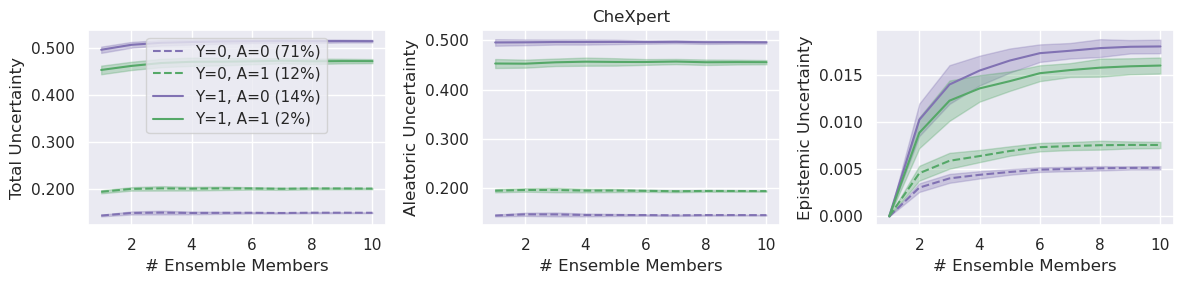

In [64]:
ensemble_members = list(range(1, len(fair_probits[0]) + 1))
eps = 1e-10

f, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
    
fair_m_total_y0_a0, fair_m_total_y1_a0, fair_m_total_y0_a1, fair_m_total_y1_a1 = list(), list(), list(), list()
fair_m_ale_y0_a0, fair_m_ale_y1_a0, fair_m_ale_y0_a1, fair_m_ale_y1_a1 = list(), list(), list(), list()
fair_m_epi_y0_a0, fair_m_epi_y1_a0, fair_m_epi_y0_a1, fair_m_epi_y1_a1 = list(), list(), list(), list()

for em in ensemble_members:
    probits = torch.stack(fair_probits)
    S, M, N, P = probits.shape
    preds = probits[:, :em]
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2)
    
    fair_m_total_y0_a0.append(total[:, (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=1))
    fair_m_total_y1_a0.append(total[:, (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=1))
    fair_m_total_y0_a1.append(total[:, (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=1))
    fair_m_total_y1_a1.append(total[:, (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=1))
    fair_m_ale_y0_a0.append(ale[:, (y_fair_t == 0) & (a_fair_t == 0)].mean(dim=1))
    fair_m_ale_y1_a0.append(ale[:, (y_fair_t == 1) & (a_fair_t == 0)].mean(dim=1))
    fair_m_ale_y0_a1.append(ale[:, (y_fair_t == 0) & (a_fair_t == 1)].mean(dim=1))
    fair_m_ale_y1_a1.append(ale[:, (y_fair_t == 1) & (a_fair_t == 1)].mean(dim=1))
    fair_m_epi_y0_a0.append((total[:, (y_fair_t == 0) & (a_fair_t == 0)] - ale[:, (y_fair_t == 0) & (a_fair_t == 0)]).mean(dim=1))
    fair_m_epi_y1_a0.append((total[:, (y_fair_t == 1) & (a_fair_t == 0)] - ale[:, (y_fair_t == 1) & (a_fair_t == 0)]).mean(dim=1))
    fair_m_epi_y0_a1.append((total[:, (y_fair_t == 0) & (a_fair_t == 1)] - ale[:, (y_fair_t == 0) & (a_fair_t == 1)]).mean(dim=1))
    fair_m_epi_y1_a1.append((total[:, (y_fair_t == 1) & (a_fair_t == 1)] - ale[:, (y_fair_t == 1) & (a_fair_t == 1)]).mean(dim=1))


fair_m_total_y0_a0 = torch.stack(fair_m_total_y0_a0)
fair_m_total_y1_a0 = torch.stack(fair_m_total_y1_a0)
fair_m_total_y0_a1 = torch.stack(fair_m_total_y0_a1)
fair_m_total_y1_a1 = torch.stack(fair_m_total_y1_a1)
fair_m_ale_y0_a0 = torch.stack(fair_m_ale_y0_a0)
fair_m_ale_y1_a0 = torch.stack(fair_m_ale_y1_a0)
fair_m_ale_y0_a1 = torch.stack(fair_m_ale_y0_a1)
fair_m_ale_y1_a1 = torch.stack(fair_m_ale_y1_a1)
fair_m_epi_y0_a0 = torch.stack(fair_m_epi_y0_a0)
fair_m_epi_y1_a0 = torch.stack(fair_m_epi_y1_a0)
fair_m_epi_y0_a1 = torch.stack(fair_m_epi_y0_a1)
fair_m_epi_y1_a1 = torch.stack(fair_m_epi_y1_a1)

for t, test_ent in enumerate([fair_m_total_y0_a0, fair_m_total_y0_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([fair_m_total_y1_a0, fair_m_total_y1_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[0].set_ylabel("Total Uncertainty")
for t, test_ent in enumerate([fair_m_ale_y0_a0, fair_m_ale_y0_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([fair_m_ale_y1_a0, fair_m_ale_y1_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[1].set_ylabel("Aleatoric Uncertainty")
for t, test_ent in enumerate([fair_m_epi_y0_a0, fair_m_epi_y0_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([fair_m_epi_y1_a0, fair_m_epi_y1_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_fair) * (p_a_fair if t == 1 else 100 - p_a_fair) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[2].set_ylabel("Epistemic Uncertainty")
axs[0].legend(loc="upper center")

axs[1].set_title("CheXpert")

for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_uncertainty_ya.pdf"))
plt.show()

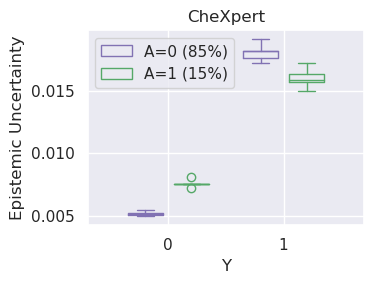

In [65]:
plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([fair_m_epi_y0_a0, fair_m_epi_y0_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 - 0.2], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
for t, test_ent in enumerate([fair_m_epi_y1_a0, fair_m_epi_y1_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 + 0.8], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("CheXpert")
plt.ylabel("Epistemic Uncertainty")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_fair if t == 1 else 100 - p_a_fair):.0f}%)") for t in range(2)])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_epi_ya.pdf"))
plt.show()

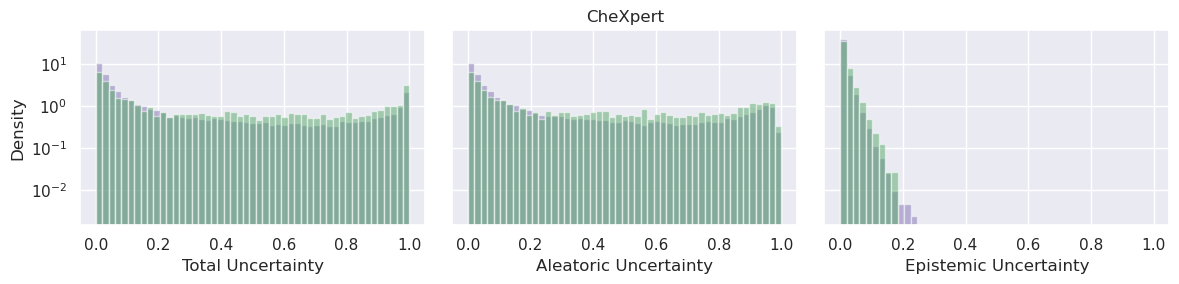

In [66]:
use_density=True
bins = np.linspace(0, 1, 50)
eps = 1e-10

f, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    
for u, uncertainty in enumerate(["Total", "Aleatoric", "Epistemic"]):

    preds = torch.stack(fair_probits)
    S, M, N, P = preds.shape
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1) / np.log(2)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2) / np.log(2)

    if uncertainty == "Total":
        fair_m_unc_1 = total[:, a_fair_t == 1]
        fair_m_unc_0 = total[:, a_fair_t == 0]
    elif uncertainty == "Aleatoric":
        fair_m_unc_1 = ale[:, a_fair_t == 1]
        fair_m_unc_0 = ale[:, a_fair_t == 0]
    elif uncertainty == "Epistemic":
        fair_m_unc_1 = total[:, a_fair_t == 1] - ale[:, a_fair_t == 1]
        fair_m_unc_0 =  total[:, a_fair_t == 0] - ale[:, a_fair_t == 0]

    axs[u].hist(fair_m_unc_0[0], bins, alpha=0.5, label="A=0", density=use_density, color=["C4", "C2"][0])
    axs[u].hist(fair_m_unc_1[0], bins, alpha=0.5, label="A=1", density=use_density, color=["C4", "C2"][1])
    axs[u].set_yscale("log")

axs[0].set_xlabel("Total Uncertainty")
axs[1].set_xlabel("Aleatoric Uncertainty")
axs[2].set_xlabel("Epistemic Uncertainty")

axs[1].set_title("CheXpert")

axs[0].set_ylabel("Density" if use_density else "Count") 

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_medical_imaging_pa{pa}_{model}_uncertainty_compact.pdf"))
plt.show()

In [67]:
print("#" * 80)
print(f"CheXpert Test Set | Protected Attribute: {pas[pa]}")
print("#" * 80)

# Individual models
# only first model per seed
print("Individual Models:")
print(f"AUROC: Mean = {np.mean(np.asarray(fair_aurocs)[:, 0] * 100):.2f}, Std = {np.std(np.asarray(fair_aurocs)[:, 0] * 100):.2f}")
print(f"SPD: Mean = {np.mean(np.asarray(fair_spds)[:, 0]):.4f}, Std = {np.std(np.asarray(fair_spds)[:, 0]):.4f}")
print(f"EOD: Mean = {np.mean(np.asarray(fair_eods)[:, 0]):.4f}, Std = {np.std(np.asarray(fair_eods)[:, 0]):.4f}")
print(f"AOD: Mean = {np.mean(np.asarray(fair_aods)[:, 0]):.4f}, Std = {np.std(np.asarray(fair_aods)[:, 0]):.4f}")
print("-" * 80)

# all models over all seeds
print("Individual Models (all):")
print(f"AUROC: Mean = {np.mean(np.asarray(fair_aurocs) * 100):.2f}, Std = {np.std(np.asarray(fair_aurocs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(fair_spds):.4f}, Std = {np.std(fair_spds):.4f}")
print(f"EOD: Mean = {np.mean(fair_eods):.4f}, Std = {np.std(fair_eods):.4f}")
print(f"AOD: Mean = {np.mean(fair_aods):.4f}, Std = {np.std(fair_aods):.4f}")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
fairest_auroc_spd = np.asarray(fair_aurocs)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"Accuracy (AUROC): Mean = {np.mean(fairest_auroc_spd * 100):.2f}, Std = {np.std(fairest_auroc_spd * 100):.2f}")
fairest_spds = np.asarray(fair_spds)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_auroc_eod = np.asarray(fair_aurocs)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_auroc_eod * 100):.2f}, Std = {np.std(fairest_auroc_eod * 100):.2f}")
fairest_eods = np.asarray(fair_eods)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_auroc_aod = np.asarray(fair_aurocs)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_auroc_aod * 100):.2f}, Std = {np.std(fairest_auroc_aod * 100):.2f}")
fairest_aods = np.asarray(fair_aods)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# BMA
print("Uniform Average:")
print(f"Accuracy: Mean = {np.mean(np.asarray(fair_m_aurocs) * 100):.2f}, Std = {np.std(np.asarray(fair_m_aurocs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(fair_m_spds):.4f}, Std = {np.std(fair_m_spds):.4f}")
print(f"EOD: Mean = {np.mean(fair_m_eods):.4f}, Std = {np.std(fair_m_eods):.4f}")
print(f"AOD: Mean = {np.mean(fair_m_aods):.4f}, Std = {np.std(fair_m_aods):.4f}")
print("-" * 80)

################################################################################
CheXpert Test Set | Protected Attribute: young
################################################################################
Individual Models:
AUROC: Mean = 94.04, Std = 0.10
SPD: Mean = 0.1369, Std = 0.0026
EOD: Mean = 0.1736, Std = 0.0060
AOD: Mean = 0.1006, Std = 0.0040
--------------------------------------------------------------------------------
Individual Models (all):
AUROC: Mean = 93.99, Std = 0.15
SPD: Mean = 0.1377, Std = 0.0037
EOD: Mean = 0.1741, Std = 0.0101
AOD: Mean = 0.1014, Std = 0.0056
--------------------------------------------------------------------------------
Fairest Model (on Validation Dataset):
Accuracy (AUROC): Mean = 94.00, Std = 0.14
SPD: Mean = 0.1372, Std = 0.0036
Accuracy (EOD): Mean = 94.01, Std = 0.12
EOD: Mean = 0.1688, Std = 0.0111
Accuracy (AOD): Mean = 94.02, Std = 0.13
AOD: Mean = 0.0999, Std = 0.0063
------------------------------------------------------------

In [68]:
# Ambiguity
fair_preds = torch.stack(fair_probits).argmax(dim=3).float()
S, M, N = fair_preds.shape
print(f"CheXpert - {N} samples")

# only first model per seed
print("Individual Models:")
ambiguity = ((fair_preds[:, 0, :].sum(dim=0) != S) & (fair_preds[:, 0, :].sum(dim=0) != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# only first model per seed
print("Individual Models (all):")
ambiguity = ((fair_preds.reshape(S * M, N).sum(dim=0) != S * M) & (fair_preds.reshape(S * M, N).sum(dim=0) != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
preds = fair_preds[torch.arange(S), np.argmin(np.asarray(val_spds), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = fair_preds[torch.arange(S), np.argmin(np.asarray(val_eods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = fair_preds[torch.arange(S), np.argmin(np.asarray(val_aods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# BMA
print("Uniform Average:")
preds = torch.stack(fair_probits).mean(dim = 1).argmax(dim=-1).sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

CheXpert - 24638 samples
Individual Models:
Ambiguity: 0.0735 (1811)
--------------------------------------------------------------------------------
Individual Models (all):
Ambiguity: 0.1478 (3642)
--------------------------------------------------------------------------------
Fairest Model (on Validation Dataset):
Ambiguity (SPD): 0.0702 (1729)
Ambiguity (EOD): 0.0731 (1801)
Ambiguity (AOD): 0.0736 (1814)
--------------------------------------------------------------------------------
Uniform Average:
Ambiguity: 0.0228 (561)
--------------------------------------------------------------------------------


In [69]:
# Ambiguity
for a in [0, 1]:
    fair_preds = torch.stack(fair_probits).argmax(dim=3).float()[..., a_fair_t == a]
    S, M, N = fair_preds.shape
    print("#" * 80)
    print(f"CheXpert PA {a} - {N} samples")
    print("#" * 80)

    # only first model per seed
    print("Individual Models:")
    ambiguity = ((fair_preds[:, 0, :].sum(dim=0) != S) & (fair_preds[:, 0, :].sum(dim=0) != 0)).float()
    print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

    # only first model per seed
    print("Individual Models (all):")
    ambiguity = ((fair_preds.reshape(S * M, N).sum(dim=0) != S * M) & (fair_preds.reshape(S * M, N).sum(dim=0) != 0)).float()
    print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

    # Fairest model on Validation dataset
    print("Fairest Model (on Validation Dataset):")
    preds = fair_preds[torch.arange(S), np.argmin(np.asarray(val_spds), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    preds = fair_preds[torch.arange(S), np.argmin(np.asarray(val_eods), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    preds = fair_preds[torch.arange(S), np.argmin(np.asarray(val_aods), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

    # BMA
    print("Uniform Average:")
    preds = torch.stack(fair_probits).mean(dim = 1).argmax(dim=-1).sum(dim = 0)[..., a_fair_t == a]
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

################################################################################
CheXpert PA 0 - 21038 samples
################################################################################
Individual Models:
Ambiguity: 0.0697 (1466)
--------------------------------------------------------------------------------
Individual Models (all):
Ambiguity: 0.1393 (2930)
--------------------------------------------------------------------------------
Fairest Model (on Validation Dataset):
Ambiguity (SPD): 0.0660 (1389)
Ambiguity (EOD): 0.0684 (1440)
Ambiguity (AOD): 0.0693 (1457)
--------------------------------------------------------------------------------
Uniform Average:
Ambiguity: 0.0214 (451)
--------------------------------------------------------------------------------
################################################################################
CheXpert PA 1 - 3600 samples
################################################################################
Individual Models:
Ambigui